In [1]:
import pandas
import requests

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)

In [2]:
r = requests.get("https://raw.githubusercontent.com/lutydlitatova/czechitas-datasets/main/datasets/movies.csv")
open("movies.csv", "wb").write(r.content)

9178038

In [3]:
data = pandas.read_csv("movies.csv")
data

,title,genre,text
0,Santa Barbara (2014),romance,"Because of his close friend's betrayal, music ..."
1,Behen Hogi Teri (2017),comedy,"Gattu (Rajkummar Rao) has a problem, he loves ..."
2,The Last Coffin (2003),horror,"In the movie, a strange crossword puzzle start..."
3,Lady Krampus (2016),horror,"It's Christmas time in Cleveland, Ohio and fou..."
4,"""Pandemic"" (2016)",thriller,A deadly virus is unleashed on the fictional n...
...,...,...,...
14903,W.M.D. (2009),thriller,It's 2002; America and the UK are pushing hard...
14904,Laramie Mountains (1952),western,Markham and his men have found gold on the Ind...
14905,"""Tycoon"" (2017)",thriller,"In Miami, a young woman Natalie Boyle gets a s..."
14906,"""Louis Grant"" (2012)",comedy,Louis now has sole responsibility for his nine...


In [4]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

<AxesSubplot:>

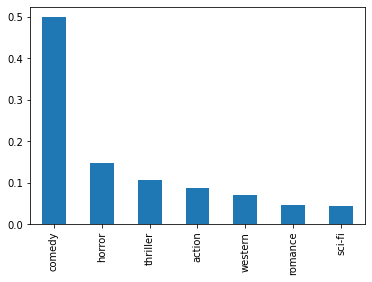

In [5]:
y_train.value_counts(normalize=True).plot(kind="bar")

Pomůžeme si třídou CountVectorizer z balíčku scikit-learn. Můžeme se podívat i na implementaci ve zdrojovém kódu, která není nijak zvlášť složitá: https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/feature_extraction/text.py#L884

In [6]:
vec = CountVectorizer()
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

In [7]:
df = pandas.DataFrame.sparse.from_spmatrix(X_train)
df.columns = vec.get_feature_names_out()
df

,00,000,003,007,0074,0077,01,05pm,06,07,...,ł10,ł400,ł500,ł5000,řker,ťgoes,ťknow,ťthe,źs,žš
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11178,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.sum().sort_values(ascending=False)

the           62607
to            36413
and           36267
of            28203
in            20087
              ...  
jordanians        1
jordaan           1
jor               1
joong             1
žš                1
Length: 49445, dtype: int64

<AxesSubplot:>

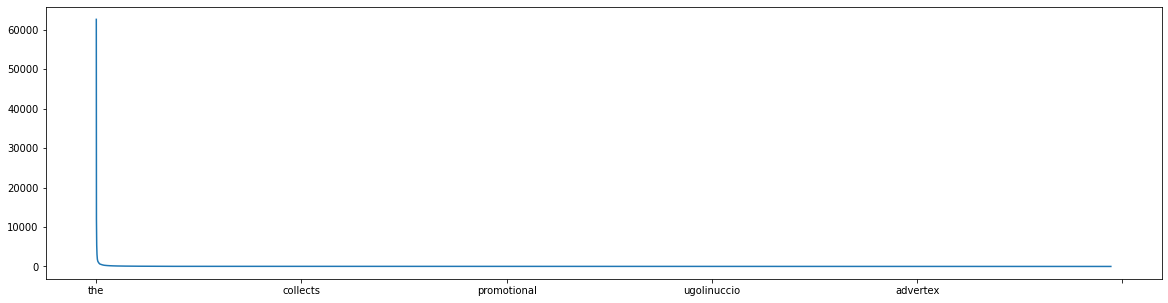

In [9]:
df.sum().sort_values(ascending=False).plot(figsize=(20, 5))

In [10]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [11]:
confusion_matrix(y_test, y_pred)

array([[  30,  277,    9,    2,    4,    4,    3],
       [  51, 1756,   29,    0,    4,   17,    5],
       [  21,  473,   37,    1,    4,   13,    2],
       [   3,  160,    3,    1,    0,    1,    0],
       [   7,  140,    7,    0,    5,    1,    1],
       [  13,  353,   13,    0,    1,   14,    4],
       [  12,  193,    4,    0,    0,    3,   46]])

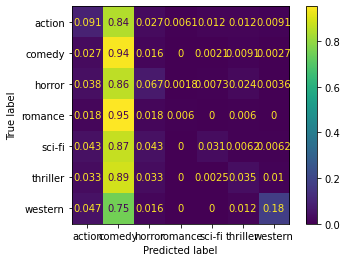

In [12]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize="true")

druhý sloupec = kolik % z žánru (v řádku) jsme označili jako komedii. Správně přiřazené = úhlopříčka z levého horního rohu do pravého spodního rohu.

In [13]:
f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.51', 'f1 score: 0.39')

accuracy je v případě disproporčních dat zavádějící

Jak můžeme úspěšnost modelu zlepšit? V podstatě jsou dvě úrovně: Úroveň dat, a úroveň klasifikačního algoritmu. Pojďme začít u dat, protože když nebudeme mít čistá data, žádný algoritmus nás nezachrání (toto se dá také shrnout pořekadlem "garbage in, garbage out").

Všimněme si, že nejčastější slova jsou taková, která se nacházejí skoro ve všech popiskách. Těmto častým slovům, která nenesou žádný význam, se říka stop words. Každý jazyk má svůj blacklist těchto slov, která se většinou z dat úplně vyfiltrují. CountVectorizer má parametr stop_words, který můžeme nastavit na hodnotu "english".

Trochu si zjednodušíme práci, a spojíme krok přípravy dat a klasifikátoru do jednoho:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [17]:
pipeline = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("clf", KNeighborsClassifier(n_neighbors=10)),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.51', 'f1 score: 0.36')

Přidání stop_words="english" nám spíše uškodilo - accuracy stejné, f1 score horší

Dále se zamysleme nad tím, co znamenají hodnoty našich vstupních proměnných. Možná by bylo lepší tyto hodnoty nějak normalizovat ( co kdybychom například měli veliké rozdíly mezi délkou vstupních dokumentů?). Populární metoda pro normalizaci četností slov je TF-IDF. Tato normalizace zohledňuje jak četnost slova v dokumentu, tak i to, jak často se objevuje vůbec v celých vstupních datech. Takže slovo, které by se velmi často objevovalo jen v několika dokumentech, by mělo větší váhu, než jiné slovo, které se objevuje v mnoha dokumentech, s malým zastoupením.

In [18]:
pipeline = Pipeline(
    [
        ("vec", TfidfVectorizer(stop_words="english")),
        ("clf", KNeighborsClassifier(n_neighbors=10)),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.62', 'f1 score: 0.57')

In [19]:
confusion_matrix(y_test, y_pred)

array([[ 115,  154,   20,    4,    8,   20,    8],
       [  39, 1660,   82,    6,    7,   24,   44],
       [  10,  228,  280,    1,    2,   21,    9],
       [  10,  135,    4,   13,    0,    2,    4],
       [  17,   74,   19,    1,   42,    5,    3],
       [  35,  250,   66,    4,    2,   33,    8],
       [   7,   78,    5,    0,    0,    2,  166]])

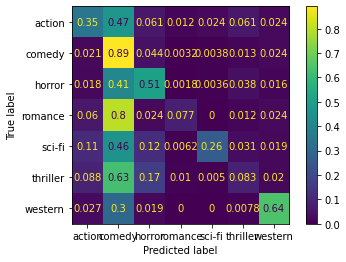

In [21]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, normalize="true")

Dále se zamysleme nad tím, kolik informace zachycujeme jednotlivými slovy. Kontext je velice důležitý. Například slovní spojení "science fiction" má jiný význam, zohledníme-li obě slova, oproti jednotlivým "science" a "fiction". Můžeme zkusit tedy do našich vstupních proměnných kromě jednotlivých slov přidat i dvojice slov, neboli "bi-gramy". Nastavíme parametr ngram_range na (1, 2), čímž říkáme, že nás obecně zajímají -tice sousedních slov od jedné do dvou (jednotlivá slova a dvojice).

In [22]:
pipeline = Pipeline(
    [
        ("vec", TfidfVectorizer(stop_words="english", ngram_range=(1,2))),
        ("clf", KNeighborsClassifier(n_neighbors=10)),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.63', 'f1 score: 0.58')

In [23]:
confusion_matrix(y_test, y_pred)

array([[ 122,  142,   21,    3,   12,   22,    7],
       [  43, 1680,   52,    6,    8,   22,   51],
       [  13,  230,  278,    1,    1,   16,   12],
       [  13,  133,    4,   11,    0,    3,    4],
       [  16,   74,   20,    0,   42,    6,    3],
       [  35,  248,   63,    6,    4,   36,    6],
       [   4,   58,    5,    0,    1,    2,  188]])

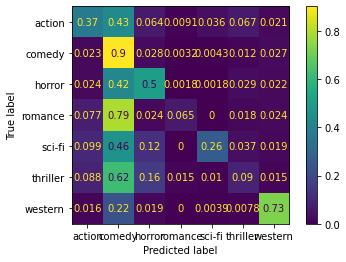

In [24]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, normalize="true")

Od dat se pak můžeme přesunout k výberu jiného algoritmu, vyzkoušejme některý z těch, které už jsme zahlédli, třeba LinearSVC.

In [28]:
pipeline = Pipeline(
    [
        ("vec", TfidfVectorizer(stop_words="english", ngram_range=(1,2))),
        ("clf", LinearSVC(random_state=0)),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.76', 'f1 score: 0.74')

In [29]:
confusion_matrix(y_test, y_pred)

array([[ 170,   83,   23,    4,   18,   28,    3],
       [  28, 1744,   42,    8,    6,   25,    9],
       [   7,   64,  452,    0,    2,   25,    1],
       [   4,  118,    3,   33,    1,    9,    0],
       [   7,   38,   28,    0,   79,    7,    2],
       [  33,  120,   89,    5,    6,  143,    2],
       [   4,   19,    3,    0,    1,    2,  229]])

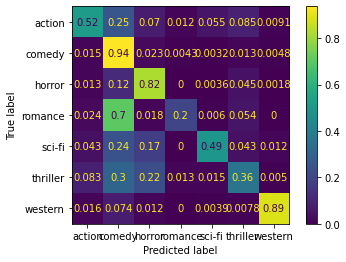

In [30]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, normalize="true")

Na závěr by nás mohlo zajímat, podle čeho se úspěšný algoritmus LinearSVC rozhodoval. Můžeme se podívat pro každou třídu na slova nebo dvojice slov, která byla pozitivně nebo negativně důležitá pro rozhodování.

In [32]:
feature_names = pipeline["vec"].get_feature_names_out()
feature_names

array(['00', '00 31', '00 bonus', ..., 'źs sit', 'žš', 'žš brand'],
      dtype=object)

In [33]:
list(enumerate(clf.classes_))

[(0, 'action'),
 (1, 'comedy'),
 (2, 'horror'),
 (3, 'romance'),
 (4, 'sci-fi'),
 (5, 'thriller'),
 (6, 'western')]

Jaké důležitosti klasifikátor přikládá jednotlivým třídám a jednotlivým vstupním proměnným?

0 - třída "action", :20 = prvních dvacet.
První řádek = negativní koeficient (20 s nejvyšším negativním koeficientem)
Druhý řádek = pozitivní koeficient (20 s nejvyšším pozitivním koeficientem)

In [38]:
neg_feats = sorted(zip(pipeline["clf"].coef_[0, :], feature_names))[:20]
pos_feats = sorted(zip(pipeline["clf"].coef_[0, :], feature_names), reverse=True)[:20]

In [39]:
neg_feats

[(-1.5834069969930455, 'comedy'),
 (-1.0681386907094599, 'house'),
 (-0.8805396868556935, 'strange'),
 (-0.8335801914235271, 'ranch'),
 (-0.8106629410945367, 'woman'),
 (-0.7683607994509648, 'space'),
 (-0.7448536369901319, 'husband'),
 (-0.6986991635272891, 'hilarious'),
 (-0.6942683315343288, 'horror'),
 (-0.6883792115730916, 'vampire'),
 (-0.6764905057704067, 'night'),
 (-0.6687762566340791, 'human'),
 (-0.6635309717791746, 'married'),
 (-0.620866485802723, 'love'),
 (-0.6156938579396946, 'arrives'),
 (-0.5965508094868024, 'year'),
 (-0.588245424339699, 'friends'),
 (-0.5795069561628521, 'new'),
 (-0.5720687534219117, 'tv'),
 (-0.5713638412215034, 'situation')]

In [40]:
pos_feats

[(2.445150383601161, 'action'),
 (2.162864472571194, 'martial'),
 (1.976577767075263, 'dragon'),
 (1.7937975472064185, 'fight'),
 (1.7010448600673744, 'fighter'),
 (1.6889553024086188, 'vs'),
 (1.6863211922683723, 'assassin'),
 (1.6728281891165429, 'martial arts'),
 (1.526214909284736, 'arts'),
 (1.490057943402774, 'killed'),
 (1.4757280149239547, 'police'),
 (1.4737232038790007, 'ninja'),
 (1.463527772543244, 'cartel'),
 (1.4278923094692106, 'singh'),
 (1.3952585988129997, 'racing'),
 (1.3856689048312336, 'crime'),
 (1.3813722906392223, 'gangsters'),
 (1.3743732176084777, 'vietnam'),
 (1.3534313416162165, 'gangs'),
 (1.347928792882327, 'wwe')]

<AxesSubplot:xlabel='feature'>

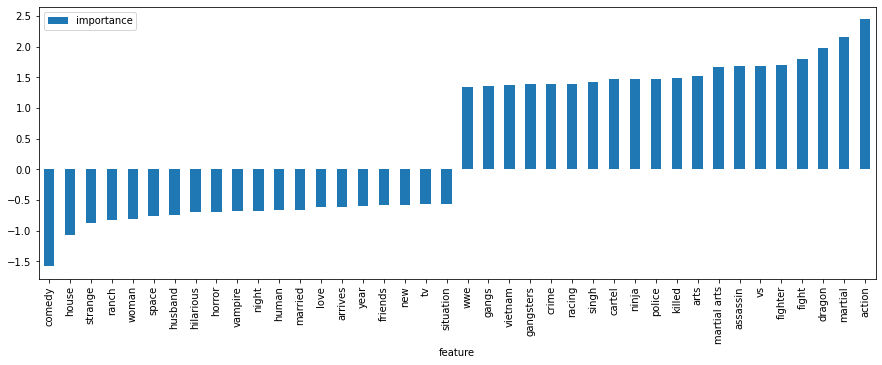

In [41]:
df = pandas.DataFrame(neg_feats + pos_feats, columns=["importance", "feature"])
df = df.set_index("feature").sort_values("importance")
df.plot(kind="bar", figsize=(15, 5))